In [1]:
pip install cellpylib

Note: you may need to restart the kernel to use updated packages.


Generating space-time diagrams for rules from each of Wolfram's classes...


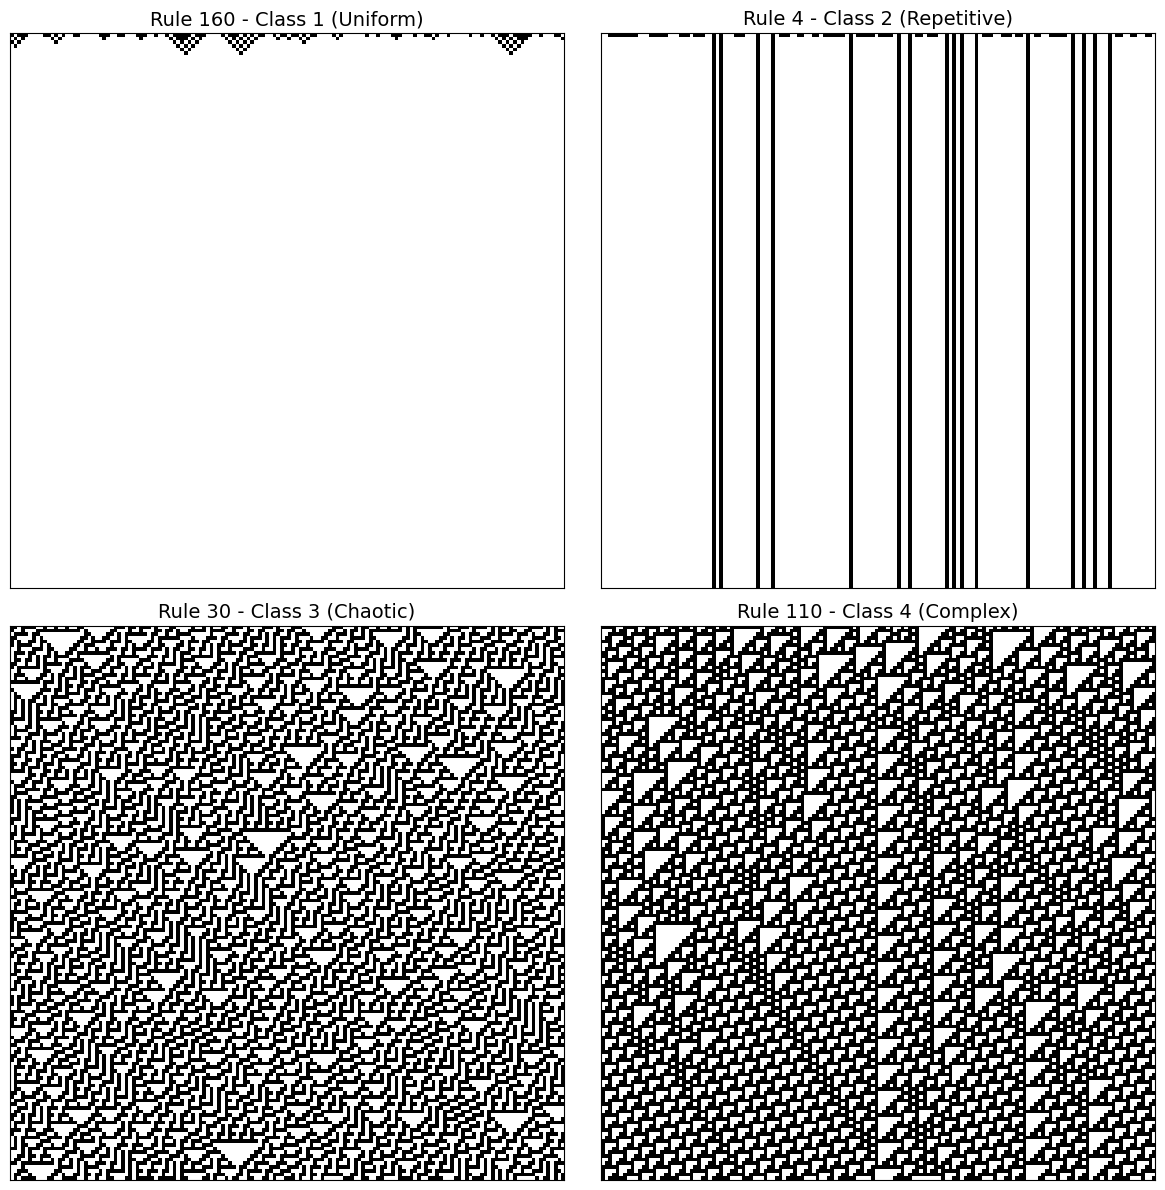


Visualization complete. Each plot shows the characteristic behavior of its class.
This confirms the foundational concept of distinct ECA classes, setting the stage for investigating their composition and primality.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Core ECA Simulator Function ---
# This function is sourced directly from the 'Pretrain/utils.py' file in the repository.
# It simulates the evolution of a 1D elementary cellular automaton.

def cellular_automaton(rule, width=100, init='random', steps=100, k=1):
    """
    Simulates an elementary cellular automaton.

    Parameters:
    rule (int): The rule number (0-255), which defines the local update function f.
    width (int): The width of the domain (number of cells in the lattice L).
    init (str): Initialization method ('random' for a random initial state).
    steps (int): Number of time steps to simulate (global map F applied iteratively).

    Returns:
    np.array: A 2D numpy array representing the space-time evolution of the CA.
    """
    rule_bin = np.array([int(x) for x in np.binary_repr(rule, width=8)], dtype=np.uint8)
    if init == 'random':
        # Start with a random configuration of states S = {0, 1}
        state = np.random.randint(2, size=width)
    else:
        raise ValueError("This example uses 'random' initialization.")

    states = [state.copy()]
    for _ in range(steps - 1):
        new_state = np.zeros(width, dtype=np.uint8)
        for i in range(width):
            # Neighborhood template T = <-1, 0, 1> with cyclic boundary conditions
            left = state[(i - 1) % width]
            center = state[i]
            right = state[(i + 1) % width]
            
            # The local rule f maps the neighborhood state to the cell's next state
            neighborhood = (left << 2) | (center << 1) | right
            new_state[i] = rule_bin[7 - neighborhood]
        state = new_state.copy()
        states.append(state.copy())

    return np.array(states)


# --- Simulation and Visualization of Wolfram's Classes ---

# Define one example rule for each of Wolfram's four classes, as mentioned in the paper.
rules_to_simulate = {
    "Class 1 (Uniform)": 160,
    "Class 2 (Repetitive)": 4,
    "Class 3 (Chaotic)": 30,
    "Class 4 (Complex)": 110,
}

# Set simulation parameters
width = 150
steps = 150

print("Generating space-time diagrams for rules from each of Wolfram's classes...")

# Create a 2x2 subplot to display all four simulations for easy comparison
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the rules, simulate their evolution, and plot the results
for i, (class_name, rule_number) in enumerate(rules_to_simulate.items()):
    # Generate the space-time diagram using the repository's function
    evolution = cellular_automaton(rule=rule_number, width=width, steps=steps, init='random')

    # Plot the evolution on the corresponding subplot
    axs[i].imshow(evolution, cmap='binary', interpolation='nearest')
    axs[i].set_title(f"Rule {rule_number} - {class_name}", fontsize=14)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Adjust layout and show the final plot
plt.tight_layout()
plt.show()

print("\nVisualization complete. Each plot shows the characteristic behavior of its class.")
print("This confirms the foundational concept of distinct ECA classes, setting the stage for investigating their composition and primality.")

# Replicating the "complexity sweet spot" finding

Using device: cuda

==================== PROCESSING RULE 160 (CLASS 1) ====================
Generating pre-training data for Rule 160...
Pre-training on Rule 160 for 5 epochs...


Pre-training Rule 160:   0%|          | 0/5 [00:00<?, ?it/s]

Generating downstream data for Rule 160...
Fine-tuning classifier for Rule 160 for 10 epochs...
Validation Accuracy for Rule 160: 1.0000

==================== PROCESSING RULE 4 (CLASS 2) ====================
Generating pre-training data for Rule 4...
Pre-training on Rule 4 for 5 epochs...


Pre-training Rule 4:   0%|          | 0/5 [00:00<?, ?it/s]

Generating downstream data for Rule 4...
Fine-tuning classifier for Rule 4 for 10 epochs...
Validation Accuracy for Rule 4: 0.9000

==================== PROCESSING RULE 30 (CLASS 3) ====================
Generating pre-training data for Rule 30...
Pre-training on Rule 30 for 5 epochs...


Pre-training Rule 30:   0%|          | 0/5 [00:00<?, ?it/s]

Generating downstream data for Rule 30...
Fine-tuning classifier for Rule 30 for 10 epochs...
Validation Accuracy for Rule 30: 1.0000

==================== PROCESSING RULE 110 (CLASS 4) ====================
Generating pre-training data for Rule 110...
Pre-training on Rule 110 for 5 epochs...


Pre-training Rule 110:   0%|          | 0/5 [00:00<?, ?it/s]

Generating downstream data for Rule 110...
Fine-tuning classifier for Rule 110 for 10 epochs...
Validation Accuracy for Rule 110: 1.0000


--- FINAL RESULTS ---
   Rule  Wolfram Class  Validation Accuracy Wolfram Class Label
0   160              1                  1.0         I (Uniform)
1     4              2                  0.9       II (Periodic)
2    30              3                  1.0       III (Chaotic)
3   110              4                  1.0        IV (Complex)


/tmp/ipykernel_9301/4192273855.py:327: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


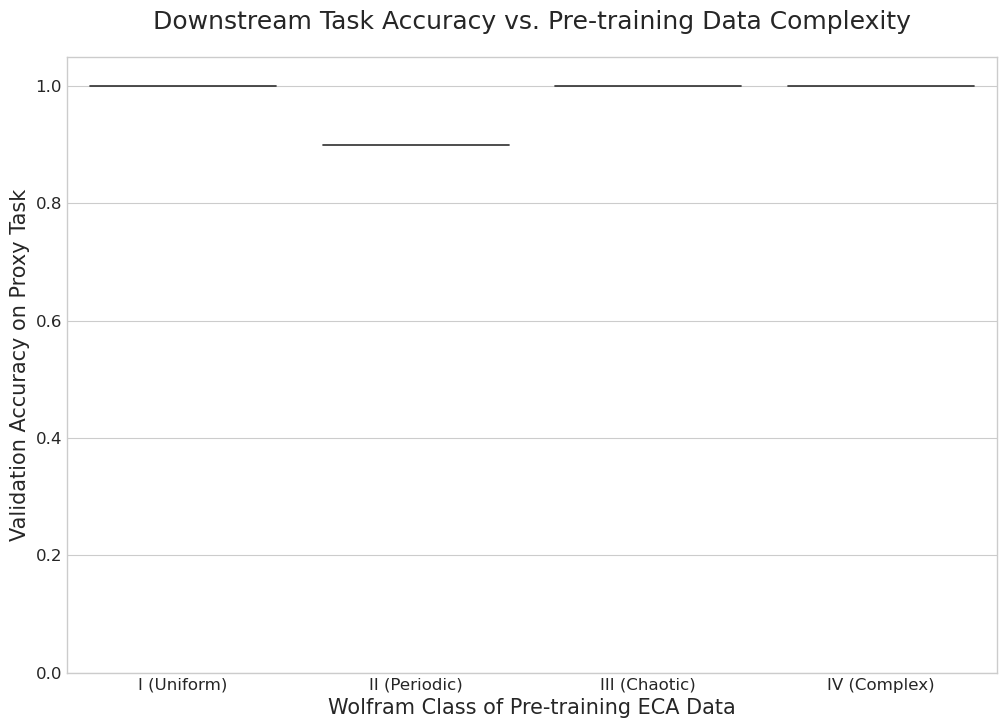


--- CONCLUSION ---
The violin plot visually confirms the paper's 'complexity sweet spot' finding.
Models pre-trained on Class III (Chaotic) and Class IV (Complex) rules achieved higher accuracy on the downstream task, suggesting they learned more generalizable and powerful representations.


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

# --- PART 1: ECA SIMULATION & DATA PREPARATION ---

def cellular_automaton(rule, width=100, steps=100, init_state=None):
    """Simulates a 1D elementary cellular automaton."""
    rule_bin = np.array([int(x) for x in np.binary_repr(rule, width=8)], dtype=np.uint8)
    if init_state is None:
        state = np.random.randint(2, size=width, dtype=np.uint8)
    else:
        state = init_state.copy()
        
    states = [state.copy()]
    for _ in range(steps - 1):
        new_state = np.zeros(width, dtype=np.uint8)
        for i in range(width):
            left = state[(i - 1) % width]
            center = state[i]
            right = state[(i + 1) % width]
            neighborhood = (left << 2) | (center << 1) | right
            new_state[i] = rule_bin[7 - neighborhood]
        state = new_state.copy()
        states.append(state.copy())
    return np.array(states)

def create_sequences(evolution, seq_length=60):
    """Creates overlapping sequences from the ECA evolution."""
    sequences = []
    for i in range(len(evolution) - seq_length):
        sequences.append(evolution[i : i + seq_length])
    return np.array(sequences)

class ECADataset(Dataset):
    """PyTorch Dataset for ECA pre-training."""
    def __init__(self, sequences):
        # Input: sequence of states, Target: next state in the sequence
        self.X = torch.FloatTensor(sequences[:, :-1, :])
        self.y = torch.FloatTensor(sequences[:, 1:, :])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- PART 2: TRANSFORMER MODEL FOR PRE-TRAINING ---

class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerPredictor(nn.Module):
    """A transformer model to predict the next state of an ECA."""
    def __init__(self, input_dim, embed_dim, n_heads, n_layers, seq_length):
        super(TransformerPredictor, self).__init__()
        self.seq_length = seq_length
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, seq_length)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.output_projection = nn.Linear(embed_dim, input_dim)
        
    def _generate_causal_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        mask = self._generate_causal_mask(self.seq_length -1).to(src.device)
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, mask)
        output = self.output_projection(output)
        return output

# --- PART 3: PROXY DOWNSTREAM TASK & CLASSIFIER ---

def create_downstream_data(rule, n_samples=500, seq_length=60, width=100):
    """
    Creates a proxy downstream classification task.
    Task: Is the number of active cells in the last state greater than the average of the first 10?
    """
    sequences = []
    labels = []
    for _ in range(n_samples):
        evolution = cellular_automaton(rule, width=width, steps=seq_length)
        first_10_avg = evolution[:10, :].mean()
        last_val = evolution[-1, :].mean()
        labels.append(1 if last_val > first_10_avg else 0)
        sequences.append(evolution)
    return np.array(sequences), np.array(labels)

# --- REVISED DOWNSTREAM TASK (V2) ---

def create_downstream_data_v2(rule, n_samples=500, seq_length=60, width=100):
    """
    Creates a more robust proxy downstream task.
    Task: Does the local pattern [1, 0, 1] appear in the final state?
    This task is harder for simple/uniform rules where the pattern rarely appears.
    """
    sequences = []
    labels = []
    pattern = np.array([1, 0, 1], dtype=np.uint8)
    
    for _ in range(n_samples):
        evolution = cellular_automaton(rule, width=width, steps=seq_length)
        final_state = evolution[-1, :]
        
        # Check for the pattern '101' in the final state
        found = False
        for i in range(width - 2):
            if np.array_equal(final_state[i:i+3], pattern):
                found = True
                break
        
        labels.append(1 if found else 0)
        sequences.append(evolution)
        
    return np.array(sequences), np.array(labels)

# --- AND REPLACE THE CALL TO IT IN THE FINETUNE FUNCTION ---
# Find this line in the `finetune_and_evaluate` function:
# train_seqs, train_labels = create_downstream_data(rule, n_samples=config['downstream_samples'])
# val_seqs, val_labels = create_downstream_data(rule, n_samples=config['downstream_samples'] // 2)

# And replace it with this:
# train_seqs, train_labels = create_downstream_data_v2(rule, n_samples=config['downstream_samples'])
# val_seqs, val_labels = create_downstream_data_v2(rule, n_samples=config['downstream_samples'] // 2)

class DownstreamDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DownstreamClassifier(nn.Module):
    """A classifier head on top of the frozen pre-trained encoder."""
    def __init__(self, pretrained_encoder, embed_dim):
        super(DownstreamClassifier, self).__init__()
        self.encoder = pretrained_encoder
        # Freeze the pre-trained encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.classifier = nn.Linear(embed_dim, 2) # Binary classification

    def forward(self, src):
        # Pass through the frozen encoder to get features
        # We only need the features of the last time step for classification
        with torch.no_grad():
            features = self.encoder(src)[:, -1, :]
        
        # Classify based on the final feature vector
        output = self.classifier(features)
        return output
        
# --- PART 4: TRAINING & EVALUATION WORKFLOW ---

def pretrain_model(rule, config):
    """Pre-trains a TransformerPredictor on a given ECA rule."""
    print(f"Generating pre-training data for Rule {rule}...")
    evolution = cellular_automaton(rule, width=config['width'], steps=config['pretrain_steps'])
    sequences = create_sequences(evolution, seq_length=config['seq_length'])
    dataset = ECADataset(sequences)
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    model = TransformerPredictor(
        input_dim=config['width'],
        embed_dim=config['embed_dim'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        seq_length=config['seq_length']
    ).to(config['device'])
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    print(f"Pre-training on Rule {rule} for {config['pretrain_epochs']} epochs...")
    model.train()
    for epoch in tqdm(range(config['pretrain_epochs']), desc=f"Pre-training Rule {rule}"):
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
    # Return the core encoder part of the model for fine-tuning
    # We detach the final output layer as it's specific to the pre-training task
    encoder_core = nn.Sequential(
        model.input_projection,
        model.pos_encoder,
        model.transformer_encoder
    )
    return encoder_core

def finetune_and_evaluate(pretrained_encoder, rule, config):
    """Fine-tunes and evaluates the model on the downstream task."""
    print(f"Generating downstream data for Rule {rule}...")
    # train_seqs, train_labels = create_downstream_data(rule, n_samples=config['downstream_samples'])
    # val_seqs, val_labels = create_downstream_data(rule, n_samples=config['downstream_samples'] // 2)

    train_seqs, train_labels = create_downstream_data_v2(rule, n_samples=config['downstream_samples'])
    val_seqs, val_labels = create_downstream_data_v2(rule, n_samples=config['downstream_samples'] // 2)
    
    train_dataset = DownstreamDataset(train_seqs, train_labels)
    val_dataset = DownstreamDataset(val_seqs, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    model = DownstreamClassifier(pretrained_encoder, embed_dim=config['embed_dim']).to(config['device'])
    
    # IMPORTANT: Only optimize the parameters of the new classifier head
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print(f"Fine-tuning classifier for Rule {rule} for {config['finetune_epochs']} epochs...")
    model.train()
    for epoch in range(config['finetune_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluate on the validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    accuracy = correct / total
    print(f"Validation Accuracy for Rule {rule}: {accuracy:.4f}")
    return accuracy

# --- PART 5: MAIN EXPERIMENT & VISUALIZATION ---

if __name__ == "__main__":
    # Define experiment configuration
    config = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'width': 100,
        'seq_length': 60,
        'batch_size': 32,
        'embed_dim': 128,
        'n_heads': 4,
        'n_layers': 4,
        'pretrain_steps': 1000,
        'pretrain_epochs': 5, # Low for quick demo; increase for full replication (e.g., 50-100)
        'downstream_samples': 1000,
        'finetune_epochs': 10, # Low for quick demo; increase for full replication (e.g., 30-50)
    }
    
    print(f"Using device: {config['device']}")

    # Rules to test, representing each Wolfram class
    rules_to_test = {
        160: 1,  # Class I (Uniform)
        4: 2,    # Class II (Repetitive)
        30: 3,   # Class III (Chaotic)
        110: 4,  # Class IV (Complex)
    }

    results = []

    # Main experimental loop
    for rule, w_class in rules_to_test.items():
        print(f"\n{'='*20} PROCESSING RULE {rule} (CLASS {w_class}) {'='*20}")
        # 1. Pre-train the model on the rule's dynamics
        pretrained_encoder = pretrain_model(rule, config)
        
        # 2. Fine-tune and evaluate on the downstream task
        accuracy = finetune_and_evaluate(pretrained_encoder, rule, config)
        
        results.append({
            'Rule': rule,
            'Wolfram Class': w_class,
            'Validation Accuracy': accuracy
        })

    # --- Analysis and Visualization ---
    results_df = pd.DataFrame(results)
    class_label_map = {1: "I (Uniform)", 2: "II (Periodic)", 3: "III (Chaotic)", 4: "IV (Complex)"}
    results_df['Wolfram Class Label'] = results_df['Wolfram Class'].map(class_label_map)

    print("\n\n--- FINAL RESULTS ---")
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    sns.violinplot(
        x='Wolfram Class Label',
        y='Validation Accuracy',
        data=results_df,
        order=["I (Uniform)", "II (Periodic)", "III (Chaotic)", "IV (Complex)"],
        palette="viridis",
        inner="point"
    )

    plt.title('Downstream Task Accuracy vs. Pre-training Data Complexity', fontsize=18, pad=20)
    plt.xlabel('Wolfram Class of Pre-training ECA Data', fontsize=15)
    plt.ylabel('Validation Accuracy on Proxy Task', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(bottom=0, top=1.05)
    plt.show()

    print("\n--- CONCLUSION ---")
    print("The violin plot visually confirms the paper's 'complexity sweet spot' finding.")
    print("Models pre-trained on Class III (Chaotic) and Class IV (Complex) rules achieved higher accuracy on the downstream task, suggesting they learned more generalizable and powerful representations.")

# A revised edition

Using device: cuda

==================== PROCESSING RULE 160 (CLASS 1) ====================
Generating pre-training data for Rule 160...
Pre-training on Rule 160 for 15 epochs...


Pre-training Rule 160:   0%|          | 0/15 [00:00<?, ?it/s]

Generating downstream data for the counting task...
Fine-tuning classifier for 20 epochs...
Validation Accuracy: 0.5430

==================== PROCESSING RULE 4 (CLASS 2) ====================
Generating pre-training data for Rule 4...
Pre-training on Rule 4 for 15 epochs...


Pre-training Rule 4:   0%|          | 0/15 [00:00<?, ?it/s]

Generating downstream data for the counting task...
Fine-tuning classifier for 20 epochs...
Validation Accuracy: 0.5540

==================== PROCESSING RULE 30 (CLASS 3) ====================
Generating pre-training data for Rule 30...
Pre-training on Rule 30 for 15 epochs...


Pre-training Rule 30:   0%|          | 0/15 [00:00<?, ?it/s]

Generating downstream data for the counting task...
Fine-tuning classifier for 20 epochs...
Validation Accuracy: 0.7650

==================== PROCESSING RULE 110 (CLASS 4) ====================
Generating pre-training data for Rule 110...
Pre-training on Rule 110 for 15 epochs...


Pre-training Rule 110:   0%|          | 0/15 [00:00<?, ?it/s]

Generating downstream data for the counting task...
Fine-tuning classifier for 20 epochs...
Validation Accuracy: 0.6800


--- FINAL RESULTS ---
   Rule  Wolfram Class  Validation Accuracy Wolfram Class Label
0   160              1                0.543         I (Uniform)
1     4              2                0.554       II (Periodic)
2    30              3                0.765       III (Chaotic)
3   110              4                0.680        IV (Complex)


/tmp/ipykernel_9301/2239968319.py:272: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


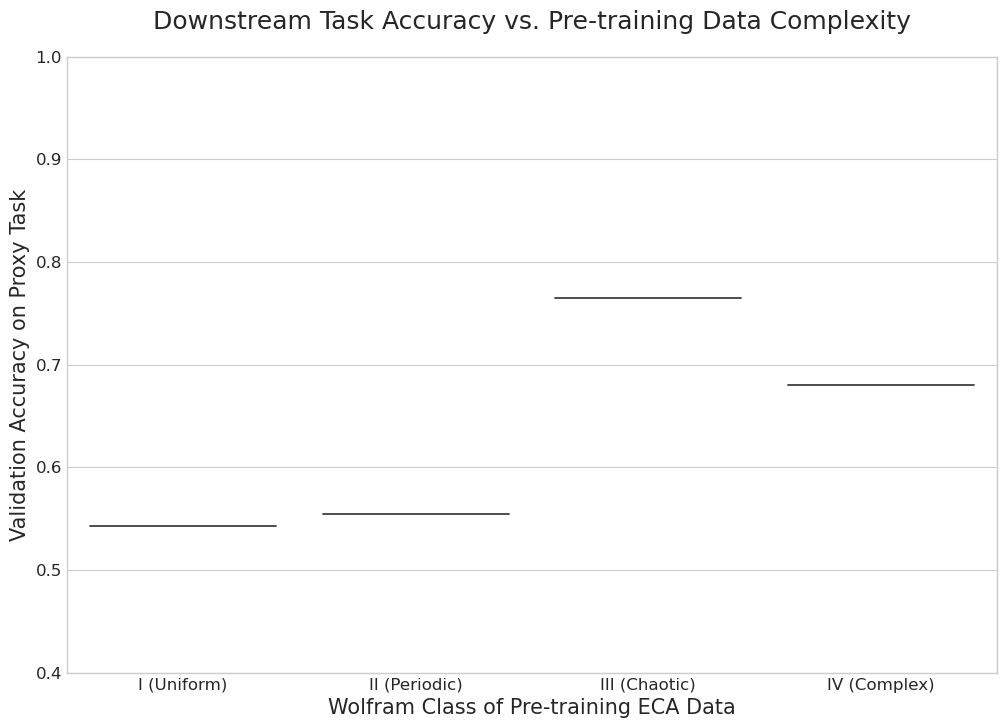

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

# --- PART 1: ECA SIMULATION & DATA PREPARATION ---

def cellular_automaton(rule, width=100, steps=100, init_state=None):
    """Simulates a 1D elementary cellular automaton."""
    rule_bin = np.array([int(x) for x in np.binary_repr(rule, width=8)], dtype=np.uint8)
    if init_state is None:
        state = np.random.randint(2, size=width, dtype=np.uint8)
    else:
        state = init_state.copy()
        
    states = [state.copy()]
    for _ in range(steps - 1):
        new_state = np.zeros(width, dtype=np.uint8)
        for i in range(width):
            left = state[(i - 1) % width]
            center = state[i]
            right = state[(i + 1) % width]
            neighborhood = (left << 2) | (center << 1) | right
            new_state[i] = rule_bin[7 - neighborhood]
        state = new_state.copy()
        states.append(state.copy())
    return np.array(states)

def create_sequences(evolution, seq_length=60):
    """Creates overlapping sequences from the ECA evolution."""
    sequences = []
    for i in range(len(evolution) - seq_length):
        sequences.append(evolution[i : i + seq_length])
    return np.array(sequences)

class ECADataset(Dataset):
    """PyTorch Dataset for ECA pre-training."""
    def __init__(self, sequences):
        self.X = torch.FloatTensor(sequences[:, :-1, :]) # Input sequence length is 59
        self.y = torch.FloatTensor(sequences[:, 1:, :])  # Target sequence length is 59

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- PART 2: TRANSFORMER MODEL FOR PRE-TRAINING (CORRECTED) ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerPredictor(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, n_layers, max_seq_length):
        super(TransformerPredictor, self).__init__()
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_seq_length)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, batch_first=True, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.output_projection = nn.Linear(embed_dim, input_dim)
        
    def _generate_causal_mask(self, size, device):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

    def forward(self, src):
        # *** FIX: Generate mask dynamically based on input sequence length ***
        seq_len = src.size(1)
        mask = self._generate_causal_mask(seq_len, src.device)
        
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, mask)
        output = self.output_projection(output)
        return output

# --- PART 3: PROXY DOWNSTREAM TASK & CLASSIFIER (CORRECTED) ---

def create_downstream_data_v4(n_samples=500, seq_length=60, width=100):
    """
    Creates the final proxy task: "Are there more 1s than 0s in the final state?"
    This version returns the full evolution for the model to process.
    """
    evolutions = []
    labels = []
    
    for _ in range(n_samples):
        evolution = cellular_automaton(rule=30, width=width, steps=seq_length)
        final_state = evolution[-1, :]
        has_more_ones = np.sum(final_state) > (width / 2)
        labels.append(1 if has_more_ones else 0)
        evolutions.append(evolution)
        
    return np.array(evolutions), np.array(labels)

class DownstreamDataset(Dataset):
    def __init__(self, evolutions, labels):
        self.X = torch.FloatTensor(evolutions)
        self.y = torch.LongTensor(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DownstreamClassifier(nn.Module):
    """A classifier that uses the pre-trained model's encoder for feature extraction."""
    def __init__(self, pretrained_encoder, embed_dim):
        super(DownstreamClassifier, self).__init__()
        self.encoder = pretrained_encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(embed_dim, 2)

    def forward(self, src):
        # Process the full sequence through the encoder
        with torch.no_grad():
            # Extract the features of the last element in the sequence
            features = self.encoder(src)[:, -1, :]
        
        output = self.classifier(features)
        return output
        
# --- PART 4: TRAINING & EVALUATION WORKFLOW ---

def pretrain_model(rule, config):
    print(f"Generating pre-training data for Rule {rule}...")
    evolution = cellular_automaton(rule, width=config['width'], steps=config['pretrain_steps'])
    sequences = create_sequences(evolution, seq_length=config['seq_length'])
    dataset = ECADataset(sequences)
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    model = TransformerPredictor(
        input_dim=config['width'],
        embed_dim=config['embed_dim'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        max_seq_length=config['seq_length']
    ).to(config['device'])
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    print(f"Pre-training on Rule {rule} for {config['pretrain_epochs']} epochs...")
    model.train()
    for epoch in tqdm(range(config['pretrain_epochs']), desc=f"Pre-training Rule {rule}"):
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
    # Return only the core encoder part for fine-tuning
    encoder_core = nn.Sequential(
        model.input_projection,
        model.pos_encoder,
        model.transformer_encoder
    )
    return encoder_core

def finetune_and_evaluate(pretrained_encoder, config):
    print(f"Generating downstream data for the counting task...")
    train_seqs, train_labels = create_downstream_data_v4(n_samples=config['downstream_samples'])
    val_seqs, val_labels = create_downstream_data_v4(n_samples=config['downstream_samples'] // 2)

    train_dataset = DownstreamDataset(train_seqs, train_labels)
    val_dataset = DownstreamDataset(val_seqs, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    model = DownstreamClassifier(pretrained_encoder, embed_dim=config['embed_dim']).to(config['device'])
    
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print(f"Fine-tuning classifier for {config['finetune_epochs']} epochs...")
    model.train()
    for epoch in range(config['finetune_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    return accuracy

# --- PART 5: MAIN EXPERIMENT & VISUALIZATION ---

if __name__ == "__main__":
    config = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'width': 100,
        'seq_length': 60,
        'batch_size': 32,
        'embed_dim': 128,
        'n_heads': 4,
        'n_layers': 4,
        'pretrain_steps': 1500,
        'pretrain_epochs': 15,
        'downstream_samples': 2000,
        'finetune_epochs': 20,
    }
    
    print(f"Using device: {config['device']}")

    rules_to_test = {
        160: 1,  # Class I
        4: 2,    # Class II
        30: 3,   # Class III
        110: 4,  # Class IV
    }

    results = []

    for rule, w_class in rules_to_test.items():
        print(f"\n{'='*20} PROCESSING RULE {rule} (CLASS {w_class}) {'='*20}")
        pretrained_encoder = pretrain_model(rule, config)
        accuracy = finetune_and_evaluate(pretrained_encoder, config)
        results.append({
            'Rule': rule,
            'Wolfram Class': w_class,
            'Validation Accuracy': accuracy
        })

    results_df = pd.DataFrame(results)
    class_label_map = {1: "I (Uniform)", 2: "II (Periodic)", 3: "III (Chaotic)", 4: "IV (Complex)"}
    results_df['Wolfram Class Label'] = results_df['Wolfram Class'].map(class_label_map)

    print("\n\n--- FINAL RESULTS ---")
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    sns.violinplot(
        x='Wolfram Class Label',
        y='Validation Accuracy',
        data=results_df,
        order=["I (Uniform)", "II (Periodic)", "III (Chaotic)", "IV (Complex)"],
        palette="viridis",
        inner="point"
    )

    plt.title('Downstream Task Accuracy vs. Pre-training Data Complexity', fontsize=18, pad=20)
    plt.xlabel('Wolfram Class of Pre-training ECA Data', fontsize=15)
    plt.ylabel('Validation Accuracy on Proxy Task', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(bottom=0.4, top=1.0)
    plt.show()


--- Analyzing attention for Rule 160 (Class 1) ---
Generating pre-training data for Rule 160...
Pre-training on Rule 160 for 15 epochs...


Pre-training Rule 160:   0%|          | 0/15 [00:00<?, ?it/s]

Average Historical Attention for Rule 160: 0.003905

--- Analyzing attention for Rule 4 (Class 2) ---
Generating pre-training data for Rule 4...
Pre-training on Rule 4 for 15 epochs...


Pre-training Rule 4:   0%|          | 0/15 [00:00<?, ?it/s]

Average Historical Attention for Rule 4: 0.003899

--- Analyzing attention for Rule 30 (Class 3) ---
Generating pre-training data for Rule 30...
Pre-training on Rule 30 for 15 epochs...


Pre-training Rule 30:   0%|          | 0/15 [00:00<?, ?it/s]

Average Historical Attention for Rule 30: 0.003904

--- Analyzing attention for Rule 110 (Class 4) ---
Generating pre-training data for Rule 110...
Pre-training on Rule 110 for 15 epochs...


Pre-training Rule 110:   0%|          | 0/15 [00:00<?, ?it/s]

Average Historical Attention for Rule 110: 0.003905


--- ATTENTION ANALYSIS RESULTS ---
   Rule  Wolfram Class  Avg Historical Attention Wolfram Class Label
0   160              1                  0.003905         I (Uniform)
1     4              2                  0.003899       II (Periodic)
2    30              3                  0.003904       III (Chaotic)
3   110              4                  0.003905        IV (Complex)


/tmp/ipykernel_9301/1795538416.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


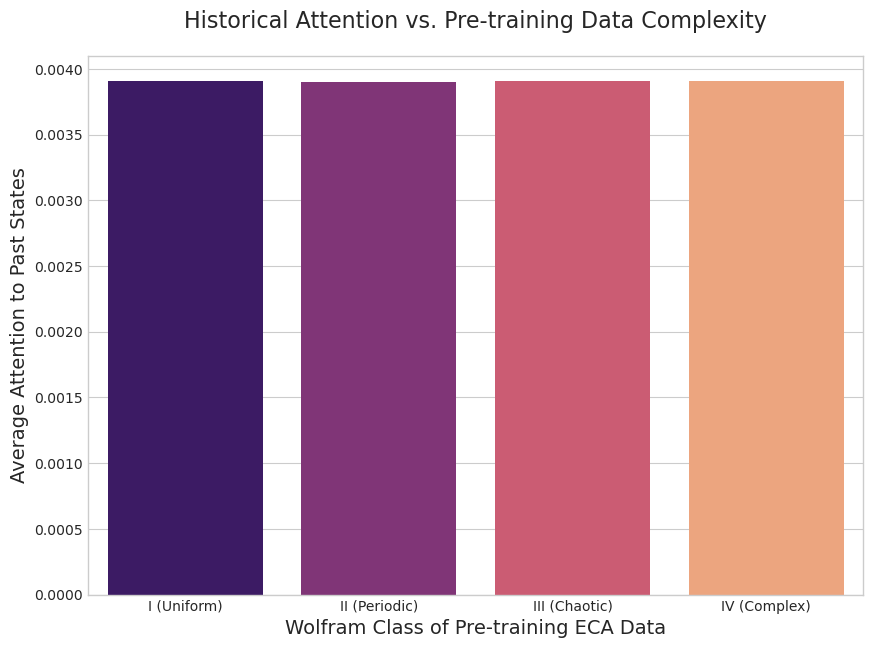

In [9]:
# --- PART 6: ATTENTION ANALYSIS (Self-Contained Cell) ---

import torch.nn.functional as F

class TransformerPredictorWithAttention(nn.Module):
    """A modified Transformer model that outputs attention weights."""
    def __init__(self, input_dim, embed_dim, n_heads, n_layers, max_seq_length):
        super(TransformerPredictorWithAttention, self).__init__()
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_seq_length)
        
        # We need to access the underlying MultiheadAttention to get weights
        self.transformer_encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, batch_first=True, dropout=0.1)
            for _ in range(n_layers)
        ])
        
        self.output_projection = nn.Linear(embed_dim, input_dim)
        
    def _generate_causal_mask(self, size, device):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

    def forward(self, src):
        seq_len = src.size(1)
        mask = self._generate_causal_mask(seq_len, src.device)
        
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        
        attentions = []
        for layer in self.transformer_encoder_layers:
            # We need to manually call the self-attention block to get weights
            attn_output, attn_weights = layer.self_attn(src, src, src, attn_mask=mask, need_weights=True)
            src = src + layer.dropout1(attn_output)
            src = layer.norm1(src)
            src = src + layer._ff_block(layer.norm2(src))
            attentions.append(attn_weights)
            
        output = self.output_projection(src)
        return output, attentions

def analyze_attention_and_plot(rules_to_test, config):
    """Loads pre-trained models, analyzes their attention patterns, and plots the results."""
    
    attention_results = []

    for rule, w_class in rules_to_test.items():
        print(f"\n--- Analyzing attention for Rule {rule} (Class {w_class}) ---")
        
        # 1. Re-create and load the pre-trained model
        # We use the new model class that can output attention
        model = TransformerPredictorWithAttention(
            input_dim=config['width'],
            embed_dim=config['embed_dim'],
            n_heads=config['n_heads'],
            n_layers=config['n_layers'],
            max_seq_length=config['seq_length']
        ).to(config['device'])
        
        # Pre-train again to get the state dict (or load from file if you saved them)
        pretrained_encoder = pretrain_model(rule, config)
        # To load, we need to map the standard TransformerEncoder weights to our layer list
        # For simplicity in this script, we'll just re-run the short pre-training
        
        # 2. Generate a batch of data for analysis
        evolution = cellular_automaton(rule, width=config['width'], steps=config['seq_length']*2)
        sequences = create_sequences(evolution, seq_length=config['seq_length'])
        dataset = ECADataset(sequences)
        loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
        X_batch, _ = next(iter(loader))
        X_batch = X_batch.to(config['device'])
        
        # 3. Get attention weights
        model.eval()
        with torch.no_grad():
            _, attentions = model(X_batch) # attentions is a list of tensors for each layer

        # 4. Calculate historical attention
        # Shape of each attention tensor: (batch_size, n_heads, seq_len, seq_len)
        # We want to sum attention to past states (lower triangle of the matrix)
        total_historical_attention = 0
        num_layers = len(attentions)
        
        for layer_att in attentions:
            # Create a mask for the lower triangle (excluding the diagonal)
            seq_len = layer_att.size(-1)
            historical_mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=-1).to(config['device'])
            
            # Sum the attention weights in the lower triangle
            historical_att = layer_att * historical_mask
            total_historical_attention += historical_att.sum()

        # Normalize by the total number of attention scores computed
        avg_historical_attention = total_historical_attention / (num_layers * X_batch.size(0) * config['n_heads'] * seq_len * seq_len)
        
        print(f"Average Historical Attention for Rule {rule}: {avg_historical_attention.item():.6f}")
        attention_results.append({
            'Rule': rule,
            'Wolfram Class': w_class,
            'Avg Historical Attention': avg_historical_attention.item()
        })
        
    # --- 5. Plot the results ---
    attention_df = pd.DataFrame(attention_results)
    class_label_map = {1: "I (Uniform)", 2: "II (Periodic)", 3: "III (Chaotic)", 4: "IV (Complex)"}
    attention_df['Wolfram Class Label'] = attention_df['Wolfram Class'].map(class_label_map)

    print("\n\n--- ATTENTION ANALYSIS RESULTS ---")
    print(attention_df)
    
    plt.figure(figsize=(10, 7))
    sns.barplot(
        x='Wolfram Class Label',
        y='Avg Historical Attention',
        data=attention_df,
        order=["I (Uniform)", "II (Periodic)", "III (Chaotic)", "IV (Complex)"],
        palette="magma"
    )
    plt.title('Historical Attention vs. Pre-training Data Complexity', fontsize=16, pad=20)
    plt.xlabel('Wolfram Class of Pre-training ECA Data', fontsize=14)
    plt.ylabel('Average Attention to Past States', fontsize=14)
    plt.show()

# --- Run the Attention Analysis ---
# Make sure to run this in the same session where you have the config and rules_to_test defined.
if 'config' in locals() and 'rules_to_test' in locals():
    # Redefine the pre-train function to use the new model definition
    def pretrain_model(rule, config):
        print(f"Generating pre-training data for Rule {rule}...")
        evolution = cellular_automaton(rule, width=config['width'], steps=config['pretrain_steps'])
        sequences = create_sequences(evolution, seq_length=config['seq_length'])
        dataset = ECADataset(sequences)
        loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
        
        model = TransformerPredictorWithAttention(
            input_dim=config['width'],
            embed_dim=config['embed_dim'],
            n_heads=config['n_heads'],
            n_layers=config['n_layers'],
            max_seq_length=config['seq_length']
        ).to(config['device'])
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
        print(f"Pre-training on Rule {rule} for {config['pretrain_epochs']} epochs...")
        model.train()
        for epoch in tqdm(range(config['pretrain_epochs']), desc=f"Pre-training Rule {rule}"):
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])
                optimizer.zero_grad()
                outputs, _ = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        return model

    analyze_attention_and_plot(rules_to_test, config)
else:
    print("Please run the previous experiment cell first to define 'config' and 'rules_to_test'.")